## Непрерывные дивиденды

В случае непрерывных дивидендов цена простого платежного обязательство?(который выплачивает $\Phi(S_T)$ долларов в момент времени $T$) задаётся формулой:
$$
V(t, s) = e^{-r(T-t)} \mathbb{E} \left[ \Phi(X_T) \right],
$$где 
$$
\begin{aligned}
   &dX_t = X_t (r-\delta) dt + X_t \sigma dW_t\\
   &X_t = s
\end{aligned}
$$

Таким образом, непрерывные дивиденды приводят к тому, что риск-нейтральная динамика процесса имеет снос $r-\delta$, а не $r$. При моделировании американских контрактов будем предполагать, что риск-нейтральная динамика процесса цены такая же.

## Регрессионная модель

Будем считать, что контракт может быть исполнен в дискретные моменты времени 
$t = t_0 < \ldots < t_N = T$. Будем обозначать цену контракта, акции в момент времени $t_i$ как $V_i(s), S_i$. Тогда стоимость контракта может быть вычислена как:
$$
\begin{aligned}
    &V_N(s) = \Phi(s)\\
    &V_i(s) = \max(\Phi(s), e^{-r(t_{i+1} - t_i)} \mathbb{E} \left[V_{i+1}(S_{{i+1}})| S_{i} = s\right] ) 
\end{aligned}
$$при $i=0,\ldots, N-1$. Обозначим
$$
C_i(s) = e^{-r(t_{i+1} - t_i)} \mathbb{E} \left[V_{i+1}(S_{i+1})| S_{i} = s\right]
$$ Обозначим оценку функции $C$ с помощью линейной регрессии как 
$$\hat{C_i}(s) = \sum_{r=1}^M \beta_{i, r} \psi_r(s)$$
Обучать модель будем следующим образом. 

1. Сгенерируем $B$ независимых траекторий, стартующих из точки $s$. $\{S^b_{0}, \ldots, S^b_{N}\}, b=\overline{1, B}$.

2. В последний момент времени положим $\hat{V}_{N} = \Phi(S^b_N)$

3. Далее, в i-ый момент времени вычислим коэффициенты МНК $\beta_{i, r} = LSM( S_i^b, e^{-r(t_{i+1}-r_{i})} \hat{V}_{i+1}^b) $

4. Вычисляем $\hat{C}_i^b = \sum_{r=1}^M \beta_{i, r} \psi_r(S_i^b)$

5. Вычисляем $\hat{V}_i^b = \max\left( \Phi(S_i^b), C_i^b\right)$

6. На последней итерации положим $\hat{V_0} = \hat{V}(t, s) = \dfrac{\sum_b \hat{V}_0^b}{B}$

Эта процедура реализована в методе fit класса RegressionPricer.

Затем полученные линейные модели можно использовать, чтобы предсказывтать цены опционов для всех моментов времени. Для этого я генерировал $B$ траекторий, стартующих в момент времени $t$ из точки $s$, исполнял их в тот момент времени $t_{i^*}:$
$$
i^* = \min \{ i : t_i \geq t, \Phi(S_i) > \hat{C_i}(S_i) \}
$$Тогда выплата опциона равна $\Phi_{S_{i^*}}$, в момент времени $t$ это будет $e^{-r(t_{i^*}-t)} \Phi_{S_{i^*}}$. Затем эта цена усреднялась по всем траекториям.

Из статьи я не до конца понял один момент. В статье предлагают обучать модель только на тех траекториях, которые в данный момент времени в деньгах. Это вполне логично, так как для траекторий не в деньгах нам нет смысла исполнять контракт в данный момент, так как есть вероятность, что в будущем он будет в деньгах. Однако тогда, когда стартавая цена сильно не в деньгах, то и все траектории будут не в деньгах, так что не получится обучить модель. Поэтому в далее я обучал модели на всех траекториях.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from numba import jit, njit
from dataclasses import dataclass, field
from abc import ABCMeta, abstractmethod
from scipy import stats as sps
import numbers
from typing import Union, Any, Callable, Sequence

In [2]:
@dataclass
class Stock:
    volatility: float
    interest_rate: float
    delta: float = 0
        

    def generate_paths(self, S: float, tn: np.ndarray, Npaths: int, match=True)->np.ndarray:
        '''
            This function generates Npaths trajectories of GBM,
            returns array of shape Npaths, Nt+1, where Nt+1 = len(tn)
        '''
        Nt = len(tn) - 1
        eps = np.zeros((Npaths, Nt + 1))
        eps[: Npaths // 2, 1:] = np.random.randn(Npaths // 2, Nt) * np.sqrt(tn[1:] - tn[:-1])
        eps[Npath // 2:, 1:] = -eps[: Npaths // 2, 1:]
        W = eps.cumsum(axis=1)
        mu = self.interest_rate - self.delta - (self.volatility ** 2) / 2
        Sn = S * np.exp( mu * tn + self.volatility * W)
        
        if match:
            mean = S * np.exp( (self.interest_rate - self.delta) * tn )
            std = mean * np.sqrt( np.exp(self.volatility ** 2 * tn) - 1.0 )

            mean = mean.reshape(1, -1)
            std = std.reshape(1, -1)

            Sn = (Sn - np.mean(Sn, axis=0)) / np.std(Sn, axis=0) * std + mean
        return Sn
    
    
    def sample_next(self, S: np.ndarray, tau: float):      
        W = np.random.randn(*S.shape) * np.sqrt( np.abs(tau) )
        mu = self.interest_rate - self.delta - (self.volatility ** 2) / 2
        return S * np.exp( mu * tau + self.volatility * W)


@dataclass
class Option:
    strike: float
    expiration_time: float

class Call(Option):
    is_call = True
    def __call__(self, s):
        return np.maximum(s - self.strike, 0)

    
class Put(Option):
    is_call = False
    def __call__(self, s):
        return np.maximum(self.strike - s, 0)

## Модель дерева

In [3]:
def tree(option: Option, stock: Stock, stock_price: float, 
         tn: np.ndarray, is_binomial=True)->float: 
    
    #
    r, vol, d = stock.interest_rate, stock.volatility, stock.delta
    #
    mu = r - d - 0.5 * (vol ** 2)
    
    if len(tn) == 1:
        return option(stock_price)
    Nt = len(tn) - 1
    dt = tn[1] - tn[0]
    
    alpha = 1.0
    if not is_binomial:
        alpha = np.sqrt(1.5)
    dy = alpha * vol * np.sqrt( dt )
    
    y = np.linspace( -Nt * dy, Nt * dy, 2 * Nt + 1 )
    
    S = stock_price * np.exp( mu * (tn[-1] - tn[0]) + y )
    
    V = option(S)
    
    for i in range(Nt - 1, -1, -1):
        S   = S * np.exp(-mu * dt)
        now = option(S)
        
        indices = np.arange(Nt - i, Nt + i + 1)
        if is_binomial:
            indices = indices[::2]
        if is_binomial:
            then = 0.5 * ( V[indices + 1] + V[indices - 1] )
        else:
            then = (1.0/3.0) * ( V[indices + 1] + V[indices] + V[indices - 1] )
        V[indices] = np.maximum(now[indices], np.exp(-r * dt) * then)
        
    return V[Nt]    

In [4]:
def binomial_tree(option: Option, stock: Stock, stock_price: float, tn: np.ndarray)->float:
    return tree(option, stock, stock_price, tn, is_binomial=True)

def trinomial_tree(option: Option, stock: Stock, stock_price: float, tn: np.ndarray)->float:
    return tree(option, stock, stock_price, tn, is_binomial=False)

In [5]:
def calc_euro(option: Option, stock: Stock, 
              stock_price: Union[float, np.ndarray], 
              tn: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
    r, vol, d = stock.interest_rate, stock.volatility, stock.delta
    
    tau = option.expiration_time - tn
    sqrttau = np.sqrt(tau) + 1e-10
    
    K = option.strike

    d1 = ( np.log(stock_price / K) + (r - d + 0.5 * vol**2) * tau ) / (vol * sqrttau)
    d2 = d1 - vol * sqrttau
    
    Phi = sps.norm.cdf
    
    C = np.exp(-d * tau) * (stock_price * Phi(d1)) - np.exp(-r * tau) * K * Phi(d2)
    P = np.exp(-r * tau) * K * Phi(-d2)  -  np.exp(-d * tau) * stock_price * Phi(-d1)
    return (C if option.is_call else P)

In [6]:
#model params
vol = 0.167
r = 0.1
d = 0.0
stock = Stock(vol, r, d)

T = 1.0
K = 100.0
call_option = Call(K, T)
put_option = Put(K, T)

In [7]:
#grid params
Nt = 20
Ns = 55

tn = np.linspace(0, T, Nt + 1)
sn = np.linspace(0.8 * K, 1.2 * K, Ns + 1)

In [8]:
V_call = np.zeros((Ns + 1, Nt + 1))
V_put = np.zeros((Ns + 1, Nt + 1))
for i in range(Ns + 1):
    for j in range(Nt + 1):
        V_call[i, j] = trinomial_tree(call_option, stock, sn[i], tn[j:])
        V_put[i, j]  = trinomial_tree(put_option,  stock, sn[i], tn[j:])

In [9]:
V_euro_call = calc_euro(call_option, stock, sn.reshape(-1, 1), tn.reshape(1, -1))
V_euro_put  = calc_euro(put_option , stock, sn.reshape(-1, 1), tn.reshape(1, -1))

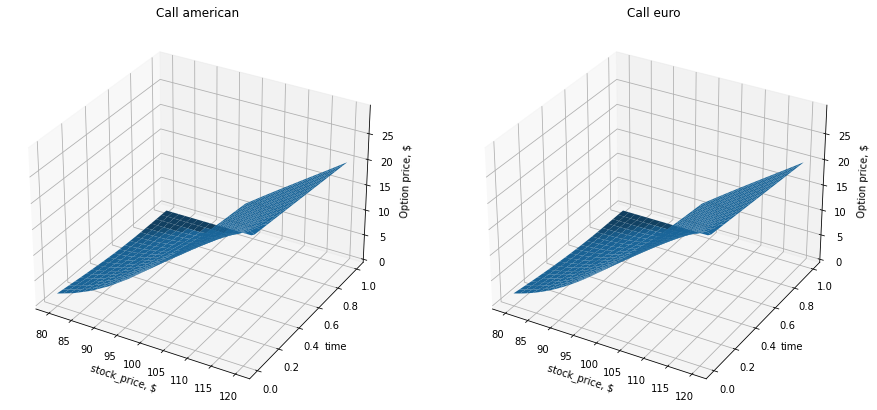

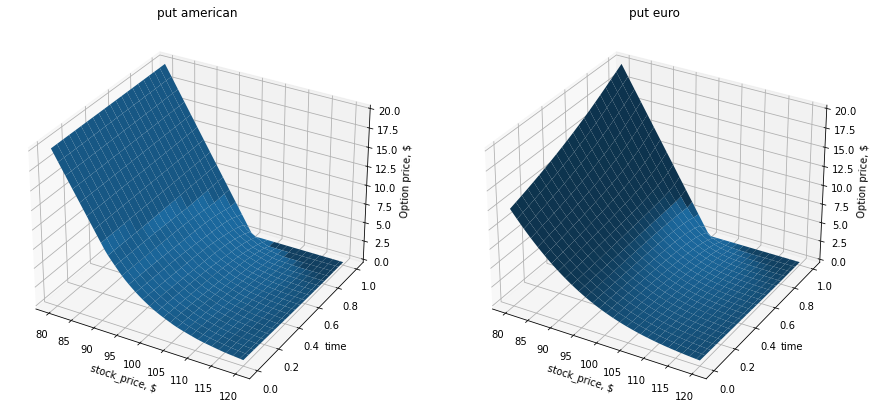

In [10]:
x, y = np.meshgrid(sn, tn, indexing='ij')
fig = plt.figure(figsize=(15, 8))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(x, y, V_call)
ax1.set_title('Call american')
ax1.set_xlabel('stock_price, $')
ax1.set_ylabel('time')
ax1.set_zlabel('Option price, $')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(x, y, V_euro_call)
ax2.set_title('Call euro')
ax2.set_xlabel('stock_price, $')
ax2.set_ylabel('time')
ax2.set_zlabel('Option price, $')

fig = plt.figure(figsize=(15, 8))
ax3 = fig.add_subplot(121, projection='3d')
ax3.plot_surface(x, y, V_put)
ax3.set_title('put american')
ax3.set_xlabel('stock_price, $')
ax3.set_ylabel('time')
ax3.set_zlabel('Option price, $')

ax4 = fig.add_subplot(122, projection='3d')
ax4.plot_surface(x, y, V_euro_put)
ax4.set_title('put euro')
ax4.set_xlabel('stock_price, $')
ax4.set_ylabel('time')
ax4.set_zlabel('Option price, $')

plt.show()



In [11]:
@njit
def make_features(x: np.ndarray, strike: float, loc=0, scale=1):
    '''
        функция принимает на вход вектор x и строит матрицу данных линейной регрессии
    '''
    n_samples = len(x)
    
    n_features = 11
    
    X = np.ones((n_samples, n_features + 1))
    
    y = (x - loc) / scale
    
    X[:, 0] = x
    X[:, 1] = x ** 2
    X[:, 2] = x ** 3
    X[:, 3] = np.maximum(x - strike, 0)
    X[:, 4] = x
    X[:, 5] = np.sin(y * np.pi)
    X[:, 6] = np.cos(y * np.pi)
    X[:, 7] = np.sin(2.0 * y * np.pi)
    X[:, 8] = np.cos(2.0 * y * np.pi)
    X[:, 9] = np.sin(3.0 * y * np.pi)
    X[:, 10] = np.cos(3.0 * y * np.pi)
    return X


@njit
def fit(x, y, loc, scale, strike, alpha=0.01):
    X = make_features(x, strike, loc, scale)
    _, n_features = X.shape
    E = np.eye(n_features)
    E[-1, -1] = 0
    w = np.linalg.solve(X.T @ X + alpha * E, X.T @ y)
    return w

@njit
def predict(x, w, loc, scale, strike):
    X = make_features(x, strike, loc, scale)
    return X @ w

In [12]:
def GeneratePaths(s: float, r: float, d:float, vol:float, 
                  tn: np.ndarray, Npaths: int, match : bool, anti: bool) -> np.ndarray:
    Nt = len(tn) - 1
    eps = np.random.randn(Npaths, Nt) * np.sqrt(tn[1:] - tn[:-1])
    if anti:
        eps[Npaths // 2 :, :] = -eps[:Npaths // 2, :]
    W = np.zeros((Npaths, Nt + 1))
    for i in range(1, Nt + 1):
        W[:, i] = W[:, i - 1] + eps[:, i - 1]
    mu = r - d - (vol ** 2) / 2
    S = s * np.exp( mu * (tn-tn[0]) + vol * W)
    if match:
        mean = s * np.exp( (r - d) * (tn-tn[0]) )
        std = mean * np.sqrt( np.exp(vol ** 2 * (tn-tn[0])) - 1.0 )

        mean = mean.reshape(1, -1)
        std = std.reshape(1, -1)
        
        assert mean.shape == (1, Nt + 1)
        assert std.shape == (1, Nt + 1)
        
        mean_ = S.mean(axis=0).reshape(1, -1)
        std_ = S.std(axis=0).reshape(1, -1) + 1e-10

        S = (S - mean_) / std_ * std + mean
    return S

## Ниже приведены вспомогательные функции обучения и предсказания модели. Для ускорения вычислений на них навешен декоратор njit.

In [106]:
def Fit(sn: np.ndarray, tn: np.ndarray, Npaths: int, r:float, d:float, vol:float, strike:float, 
       match: bool, anti: bool, fit_in_the_money : bool):
    #fit section
    Nt = len(tn) - 1
    Ns = len(sn) - 1
    paths = np.zeros((Npaths * len(sn), Nt + 1))
    for i in range(len(sn)):
        paths[i * Npaths : (i+1) * Npaths, :] = GeneratePaths(sn[i], r, d, vol, tn, Npaths, match, anti)
    
    V = np.maximum(paths[:, -1] - strike, 0.0)
    
    _, n_features = make_features(sn[:1], strike).shape
    weights = np.zeros((Nt, n_features))
    locs = np.zeros((Nt, ))
    scales = np.zeros((Nt, ))
    for i in range(Nt-1, -1, -1):
        dt = tn[i + 1] - tn[i]
        #current stock prices
        S = paths[:, i]
        continuation = np.exp(-r * dt) * V    
        expiration = np.maximum(S - strike, 0.0)
        
        #fit
        in_the_money = expiration > 0.0
        S_fit = S
        C_fit = continuation
        if fit_in_the_money:
            S_fit = S[in_the_money]
            C_fit = continuation[in_the_money]
        loc = np.mean(S_fit)
        scale = np.std(S_fit)
        
        weights[i, :] = fit(S_fit, C_fit, loc, scale, strike)
        locs[i] = loc
        scales[i] = scale
        #
        continuation_hat = predict(S, weights[i, :], loc, scale, strike)
        #updating option price
        if fit_in_the_money:
            pass
            #continuation_hat = continuation
        V = np.maximum(expiration, continuation_hat)
    
    result = np.zeros_like(sn)
    for i in range(len(sn)):
        result[i] = np.mean( V[i * Npaths : (i+1) * Npaths] )
    return result, weights, locs, scales 

In [107]:
def Predict(sn:np.ndarray, tn:np.ndarray, Npaths:int, r:float, d:float, 
            vol:float, strike:float, weights:np.ndarray, locs:np.ndarray, scales:np.ndarray,
            match, anti):
    Nt = len(tn) - 1
    Ns = len(sn) - 1
    #predict section
    result = np.zeros((len(sn), Nt + 1))

    for start in range(Nt + 1):
        #current stock prices
        paths = np.zeros((Npaths * len(sn), Nt + 1 - start))
        for i in range(len(sn)):
            paths[i * Npaths : (i+1) * Npaths, :] = GeneratePaths(sn[i], r, d, vol, tn[start:], Npaths, match, anti)
        #boolean flags
        is_done = np.asarray([False for _ in range(Npaths * len(sn))])
        
        V = np.zeros((Npaths * len(sn), ))
        S = paths[:, 0]
        for i in range(start, Nt):
            #current time
            t = tn[i] - tn[start]
            #
            expiration = np.maximum(S - strike, 0.0)
            #
            in_the_money = expiration > 0
            #
            continuation = predict(S, weights[i], locs[i], scales[i], strike)
            #we expire option now if it hasn't been expired before and if it's more profitable
            is_expire_now = ( (in_the_money) & (expiration >= continuation) & (~is_done) )
            V[is_expire_now] = np.exp(-r * t) * expiration[is_expire_now]
            is_done = (is_done | is_expire_now)
            #
            S = paths[:, i - start + 1]
        V[(~is_done)] = np.exp(-r * (tn[-1]-tn[start])) * np.maximum(paths[~is_done, -1] - strike, 0.0)
        for j in range(len(sn)):
            result[j, start] = np.mean( V[j * Npaths : (j+1) * Npaths] )
    return result

In [108]:
def PredictTrajecroty(sn, tn, Npaths, r, d, vol, strike, weights, locs, scales, match, anti):
    
    Nt = len(tn) - 1
    Ns = len(sn) - 1
    #current stock prices
    paths = np.zeros((Npaths * len(sn), Nt + 1))
    for i in range(len(sn)):
        paths[i * Npaths : (i+1) * Npaths, :] = GeneratePaths(sn[i], r, d, vol, tn, Npaths, match, anti)
    #boolean flags
    is_done = np.asarray([False for _ in range(Npaths * len(sn))])

    S = paths[:, 0]
    i_expire = np.asarray([-1 for _ in range(Npaths * len(sn))])
    for i in range(0, Nt):
        #current time
        t = tn[i] - tn[0]
        #
        expiration = np.maximum(S - strike, 0.0)
        #
        in_the_money = expiration > 0
        #
        continuation = predict(S, weights[i], locs[i], scales[i], strike)
        #we expire option now if it hasn't been expired before and if it's more profitable
        is_expire_now = ( (in_the_money) & (expiration >= continuation) & (~is_done) )

        is_done = (is_done | is_expire_now)
        
        i_expire[is_expire_now] = i
        #
        S = paths[:, i + 1]
    i_expire[~is_done] = Nt
    
    t_expire = tn[i_expire]
    s_expire = np.zeros_like(i_expire)
    for j, expire_index in enumerate(i_expire):
        paths[j, expire_index + 1:] = np.nan
        s_expire[j] = paths[j, expire_index]
    return t_expire, s_expire, paths

In [109]:
class RegressionPricer:
    def __init__(self, option, stock, Npaths, match=True, anti=True, fit_in_the_money=False):
        self._Npaths = Npaths
        self._option = option
        self._stock = stock
        
        self._match = match
        self._anti = anti
        self._fit_in_the_money = fit_in_the_money
    
    
    def fit(self, tn, sn):
        self._tn = tn
        self._sn = sn
        
        r, d, vol = self._stock.interest_rate, self._stock.delta, self._stock.volatility
        strike = self._option.strike
        
        V, self._weights, self._locs, self._scales = Fit(sn, tn, self._Npaths, r, d, vol, strike, 
                                                         self._match, self._anti, self._fit_in_the_money)
        return V
    
    
    def predict(self):
        r, d, vol = self._stock.interest_rate, self._stock.delta, self._stock.volatility
        strike = self._option.strike
        tn, sn = self._tn, self._sn
        weights, locs, scales = self._weights, self._locs, self._scales
        V = Predict(sn, tn, self._Npaths, r, d, vol, strike, weights, locs, scales, self._match, self._anti)
        return V
    
    def predict_trajectory(self, Npaths):
        r, d, vol = self._stock.interest_rate, self._stock.delta, self._stock.volatility
        strike = self._option.strike
        tn, sn = self._tn, self._sn
        weights, locs, scales = self._weights, self._locs, self._scales
        return PredictTrajecroty(sn, tn, Npaths, r, d, vol, strike, weights, locs, scales, self._match, self._anti)

In [110]:
#model params
vol = 0.167
r = 0.1
d = 0.0
stock = Stock(vol, r, d)

T = 1.0
K = 100.0
call_option = Call(K, T)

In [111]:
#grid params
Nt = 30
Ns = 10

tn = np.linspace(0, T, Nt + 1)
sn = np.linspace(0.75 * K, 1.35 * K, Ns + 1)

In [112]:
Npaths = 1000
match = True
anti = True
reg_pricer = RegressionPricer(call_option, stock, Npaths, match, anti)

In [113]:
call_prices_tree     = np.zeros((Ns + 1, ))
call_prices_reg_fit  = np.zeros((Ns + 1, ))
call_prices_reg_pred = np.zeros((Ns + 1, ))

call_prices_euro     = calc_euro(call_option, stock, sn.reshape(-1, 1), 0).reshape(-1)

In [114]:
for i in range(Ns + 1):
    call_prices_tree[i] = trinomial_tree(call_option, stock, sn[i], tn)

In [115]:
call_prices_reg_fit = reg_pricer.fit(tn, sn)
call_prices_reg_pred = reg_pricer.predict()

error fit      = 0.58053%
error predict  = 0.11363%
error tree     = 0.04662%


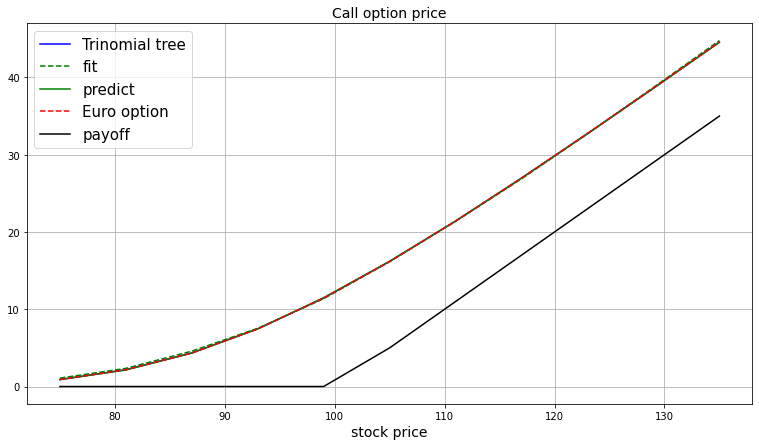

In [116]:
plt.figure(figsize=(13, 7))
plt.plot(sn, call_prices_tree, 'b', linewidth=1.5,label='Trinomial tree')
plt.plot(sn, call_prices_reg_fit, 'g--', label='fit')
plt.plot(sn, call_prices_reg_pred[:, 0], 'g', label='predict')
plt.plot(sn, call_prices_euro, 'r--', label='Euro option')
plt.plot(sn, call_option(sn), 'k', label='payoff')
plt.grid()
plt.legend(fontsize=15)
plt.title("Call option price", fontsize=14)
plt.xlabel("stock price", fontsize=14)
None

denom = 0.01 * np.linalg.norm(call_prices_euro)
error_fit = np.linalg.norm( call_prices_reg_fit - call_prices_euro ) / denom
error_pred = np.linalg.norm( call_prices_reg_pred[:, 0] - call_prices_euro ) / denom
error_tree = np.linalg.norm( call_prices_tree - call_prices_euro ) / denom

print(f'error fit      = {error_fit:0.5f}%')
print(f'error predict  = {error_pred:0.5f}%')
print(f'error tree     = {error_tree:0.5f}%')

На графике выше изображены цены американского и европейского колл-опциона. Для вычисления цены американского опциона использовались две модели: 1) троичное дерево, 2) модель из статьи на основе регрессии. Вторая модель даёт две оценки: одна завышенная, получается при обучении модели, другая заниженная -- на предсказании. Визуально видно, что цена, оценённая с помощью дерева, совпадает с ценой европейского опциона, что согласуется с теорией. Оценки, полученные с помощью регрессионной  модели, тоже близки к ценам европейского опциона, однако видно, что они сильно колеблются. 

Далее рассмотрим трёхмерные графики.

In [117]:
call_prices_tree = np.zeros((Ns + 1, Nt + 1))
for i in (range(Ns + 1)):
    for j in range(Nt + 1):
        call_prices_tree[i, j] = trinomial_tree(call_option, stock, sn[i], tn[j:])        

In [118]:
call_prices_euro = calc_euro(call_option, stock, sn.reshape(-1, 1), tn.reshape(1, -1))

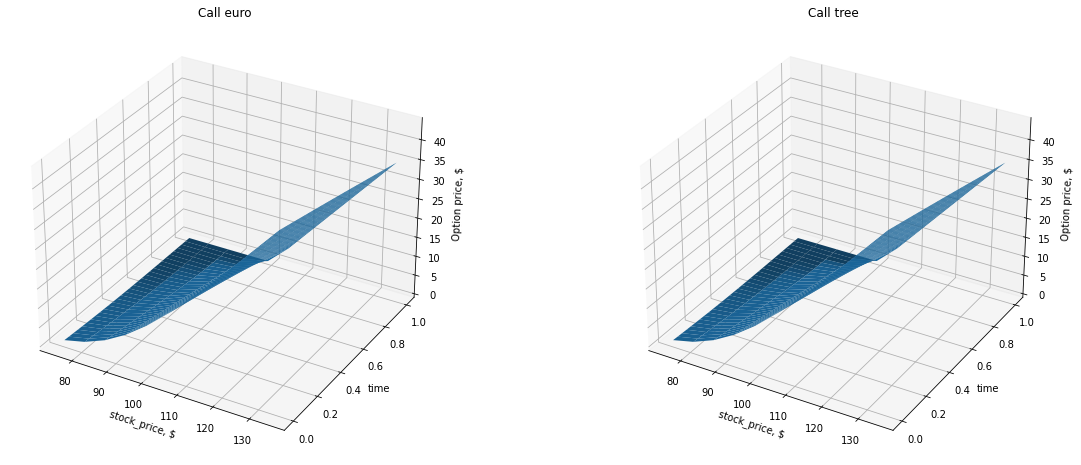

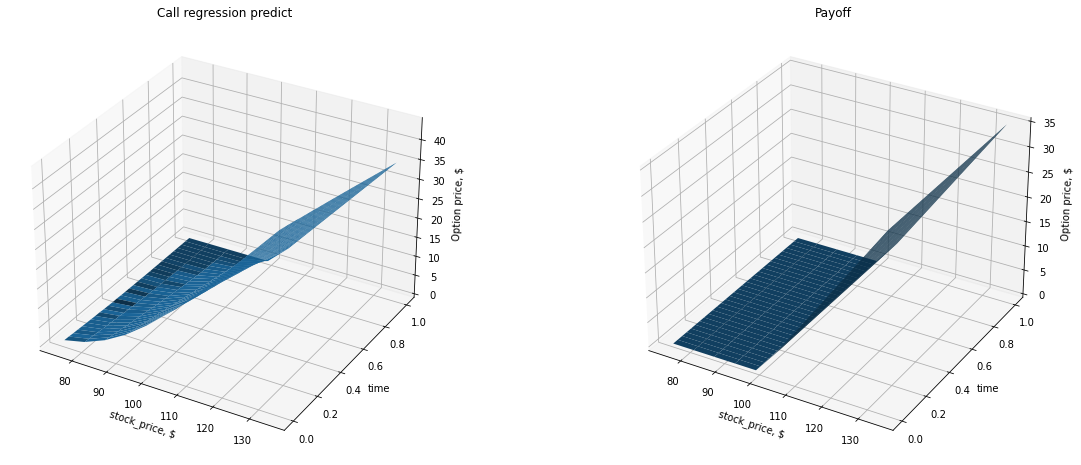

error predict  = 0.12783%
error tree     = 0.06997%


In [119]:
x, y = np.meshgrid(sn, tn, indexing='ij')
g = call_option(x)
fig = plt.figure(figsize=(20, 8))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(x, y, call_prices_euro)
ax1.set_title('Call euro')
ax1.set_xlabel('stock_price, $')
ax1.set_ylabel('time')
ax1.set_zlabel('Option price, $')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(x, y, call_prices_tree)
ax2.set_title('Call tree')
ax2.set_xlabel('stock_price, $')
ax2.set_ylabel('time')
ax2.set_zlabel('Option price, $')


fig = plt.figure(figsize=(20, 8))
ax3 = fig.add_subplot(121, projection='3d')
ax3.plot_surface(x, y, call_prices_reg_pred)
ax3.set_title('Call regression predict')
ax3.set_xlabel('stock_price, $')
ax3.set_ylabel('time')
ax3.set_zlabel('Option price, $')

ax4 = fig.add_subplot(122, projection='3d')
ax4.plot_surface(x, y, g)
ax4.set_title('Payoff')
ax4.set_xlabel('stock_price, $')
ax4.set_ylabel('time')
ax4.set_zlabel('Option price, $')
plt.show()

denom = 0.01 * np.linalg.norm( call_prices_euro )
error_pred = np.linalg.norm( call_prices_reg_pred - call_prices_euro) / denom
error_tree = np.linalg.norm( call_prices_tree - call_prices_euro ) / denom

print(f'error predict  = {error_pred:0.5f}%')
print(f'error tree     = {error_tree:0.5f}%')

## Непрерывные дивиденды

Добавим теперь ненулевые непрерывные дивиденды.

In [120]:
#model params
vol = 0.167
r = 0.1
d = 0.14
stock = Stock(vol, r, d)

T = 1.0
K = 100.0
call_option = Call(K, T)
put_option = Put(K, T)

#grid params
Nt = 30
Ns = 50

tn = np.linspace(0, T, Nt + 1)
sn = np.linspace(0.75 * K, 1.35 * K, Ns + 1)

Npaths = 2000

match=True
anti=True
fit_in_the_money=True
reg_pricer = RegressionPricer(call_option, stock, Npaths, match, anti, fit_in_the_money)

In [121]:
call_prices_tree = np.zeros((Ns + 1, ))
for i in range(Ns + 1):
    call_prices_tree[i] = trinomial_tree(call_option, stock, sn[i], tn)

call_prices_reg_fit = reg_pricer.fit(tn, sn)
call_prices_reg_pred = reg_pricer.predict()

call_prices_euro = calc_euro(call_option, stock, sn.reshape(-1, 1), 0).reshape(-1)

error fit      = 9.95126%
error predict  = 1.25923%
error tree     = 21.69627%


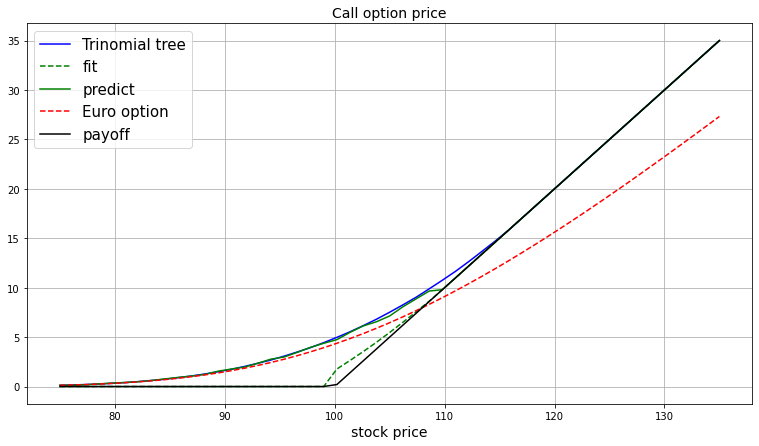

In [122]:
plt.figure(figsize=(13, 7))
plt.plot(sn, call_prices_tree, 'b', linewidth=1.5,label='Trinomial tree')
plt.plot(sn, call_prices_reg_fit, 'g--', label='fit')
plt.plot(sn, call_prices_reg_pred[:, 0], 'g', label='predict')
plt.plot(sn, call_prices_euro, 'r--', label='Euro option')
plt.plot(sn, call_option(sn), 'k', label='payoff')
plt.grid()
plt.legend(fontsize=15)
plt.title("Call option price", fontsize=14)
plt.xlabel("stock price", fontsize=14)
None

denom = 0.01 * np.linalg.norm( call_prices_tree )
error_fit = np.linalg.norm( call_prices_reg_fit - call_prices_tree ) / denom
error_pred = np.linalg.norm( call_prices_reg_pred[:, 0] - call_prices_tree) / denom
error_tree = np.linalg.norm( call_prices_tree - call_prices_euro ) / denom

print(f'error fit      = {error_fit:0.5f}%')
print(f'error predict  = {error_pred:0.5f}%')
print(f'error tree     = {error_tree:0.5f}%')

In [123]:
call_prices_tree = np.zeros((Ns + 1, Nt + 1))
for i in range(Ns + 1):
    for j in range(Nt + 1):
        call_prices_tree[i, j] = trinomial_tree(call_option, stock, sn[i], tn[j:])  
call_prices_euro = calc_euro(call_option, stock, sn.reshape(-1, 1), tn.reshape(1, -1))

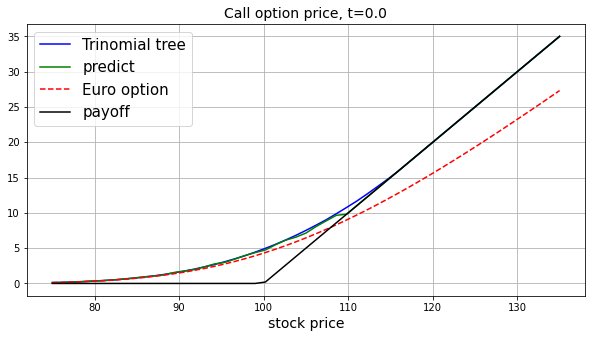

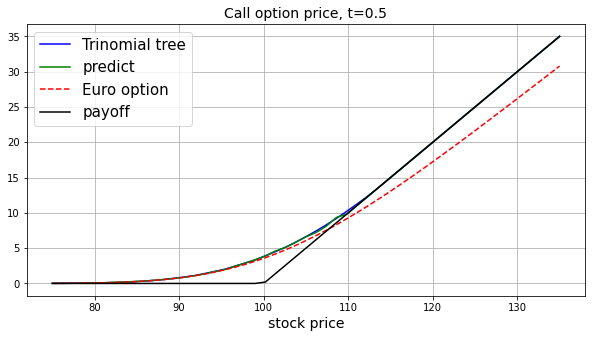

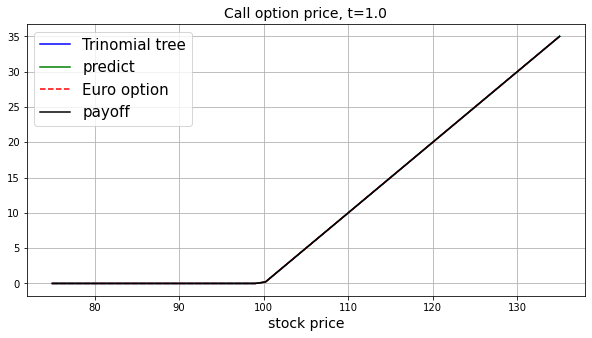

In [124]:
for i in range(0, Nt + 1, 15):
    plt.figure(figsize=(10, 5))
    plt.plot(sn, call_prices_tree[:, i], 'b', linewidth=1.5,label='Trinomial tree')
    plt.plot(sn, call_prices_reg_pred[:, i], 'g', label='predict')
    plt.plot(sn, call_prices_euro[:, i], 'r--', label='Euro option')
    plt.plot(sn, call_option(sn), 'k', label='payoff')
    plt.grid()
    plt.legend(fontsize=15)
    plt.title(f"Call option price, t={tn[i]}", fontsize=14)
    plt.xlabel("stock price", fontsize=14)
    None
plt.show()

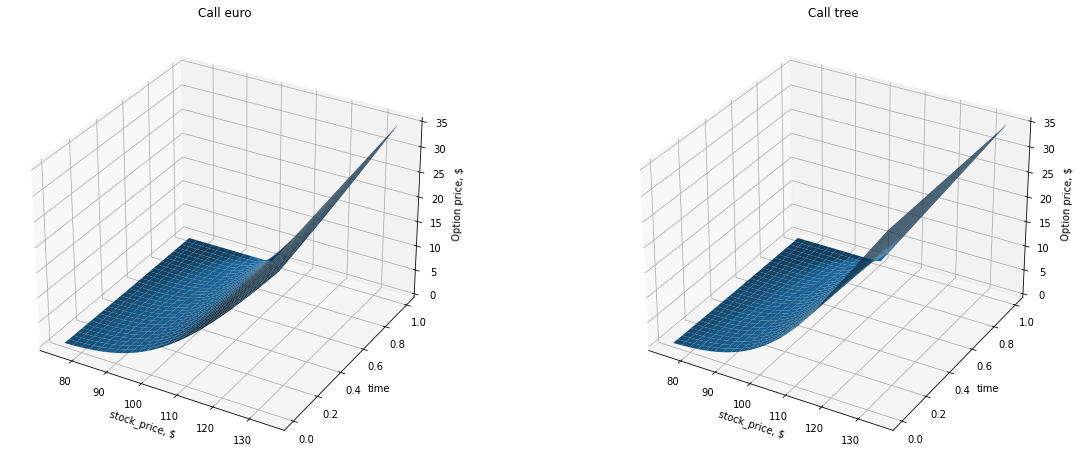

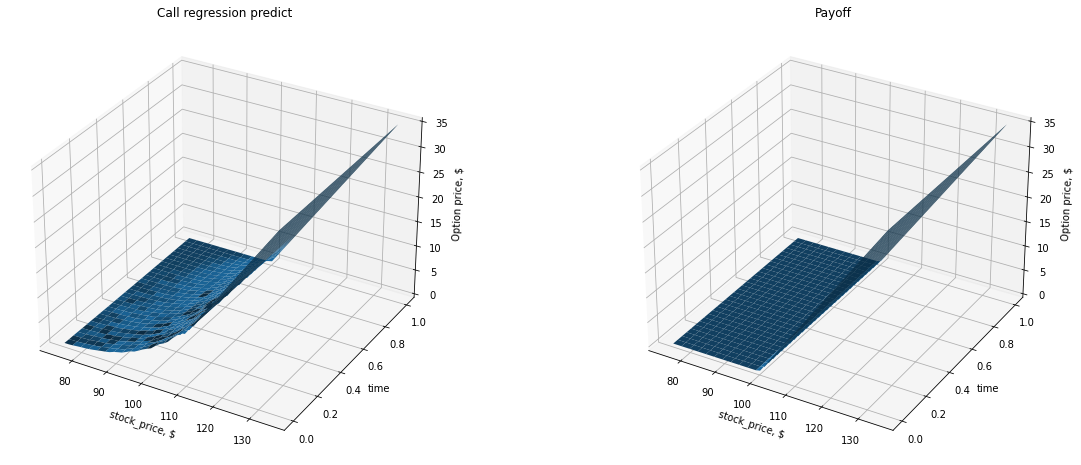

error predict  = 0.63115%
error tree     = 13.71054%


In [125]:
x, y = np.meshgrid(sn, tn, indexing='ij')
g = call_option(x)
fig = plt.figure(figsize=(20, 8))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(x, y, call_prices_euro)
ax1.set_title('Call euro')
ax1.set_xlabel('stock_price, $')
ax1.set_ylabel('time')
ax1.set_zlabel('Option price, $')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(x, y, call_prices_tree)
ax2.set_title('Call tree')
ax2.set_xlabel('stock_price, $')
ax2.set_ylabel('time')
ax2.set_zlabel('Option price, $')


fig = plt.figure(figsize=(20, 8))
ax3 = fig.add_subplot(121, projection='3d')
ax3.plot_surface(x, y, call_prices_reg_pred)
ax3.set_title('Call regression predict')
ax3.set_xlabel('stock_price, $')
ax3.set_ylabel('time')
ax3.set_zlabel('Option price, $')

ax4 = fig.add_subplot(122, projection='3d')
ax4.plot_surface(x, y, g)
ax4.set_title('Payoff')
ax4.set_xlabel('stock_price, $')
ax4.set_ylabel('time')
ax4.set_zlabel('Option price, $')
plt.show()

denom = 0.01 * np.linalg.norm( call_prices_tree )
error_pred = np.linalg.norm( call_prices_reg_pred - call_prices_tree) / denom
error_tree = np.linalg.norm( call_prices_tree - call_prices_euro ) / denom

print(f'error predict  = {error_pred:0.5f}%')
print(f'error tree     = {error_tree:0.5f}%')

Выше для модели регрессии ошибка считалась относительно модели трочиного дерева, так как её я считаю референсной. 

## Граница выхода

Обозначим цену опциона с функцией выплаты $\Phi(s)$ в момент времени $t$ при цене $s$ как $V(t, s)$. В любой момент времени выполнено неравенство $V(t, s) \geq \Phi(s)$. Рассмотрим множество:
$$
C = \{ (t, s) : V(t, s) > \Phi(s) \}
$$и его дополнение:
$$
E = \{ (t, s) : V(t, s) = \Phi(s) \} 
$$Таким образом, первое множество соответствует тому, что мы продолжаем контракт, а второе -- тому, что мы выполняем его прямо сейчас. 

Рассмотрим графики цен американских опционов в разные моменты времени. Из графиков ниже видно, что когда опцион сильно не в деньгах или сильно в деньгах, то текущая равна текущей цене опциона. Если опцион сильно не в деньгах, нам нет разницы, использовать его сейчас или потом, так как с большой вероятностью потом он тоже будет не в деньгах. Поэтому при подсчёте границы выхода их учитывать не будем. 

При дальнешем увеличении цены акции видно, что цена опциона становится выше текущей выплаты, а затем снова становится равной ей. По сути, в качестве границы выхода нужно взять ту стоимость, при которой цена опциона в деньгах становится равной текущей выплате.

In [126]:
def get_expiring_curve(option: Option, V:np.ndarray, tn:np.ndarray, sn:np.ndarray)->np.ndarray:
    '''
        Функция строит границу выхода по данной матрице цен опционов
    '''
    assert V.shape == (len(sn), len(tn))
    g = option(sn)
    B = np.zeros_like(tn)
    
    eps = 1e-5
    for j in range(len(tn)):
        #is_expire содержит множество индексов, при которых в данный момент времени 
        #опцион стоит дороже мгновенной выплаты. в качестве границы выхода мы берём
        #максимальную из таких цен.
        is_expire = np.where( V[:, j] - g > eps)[0]
        if len(is_expire):
            B[j] = sn[is_expire[-1] + 1]
    return B

In [127]:
def shrink(z):
    eps = 1e-5
    i = np.where(np.abs(z) <= eps, True, False)
    res = z.copy()
    res[i] = 0.0
    return res

In [128]:
B_tree = get_expiring_curve(call_option, call_prices_tree, tn, sn)
B_reg = get_expiring_curve(call_option, call_prices_reg_pred, tn, sn)

In [129]:
sn_mesh, _ = np.meshgrid(sn, tn, indexing='ij')
G = call_option(sn_mesh)

z_tree = call_prices_tree - G
z_tree = shrink(z_tree)
z_tree = np.sign(z_tree)
#z_tree = np.clip(z_tree, -1, 1)

z_reg = np.clip( call_prices_reg_pred - G, -1, 1)

In [130]:
Niter = 10
t_expire, s_expire, trajectory = reg_pricer.predict_trajectory(Niter)

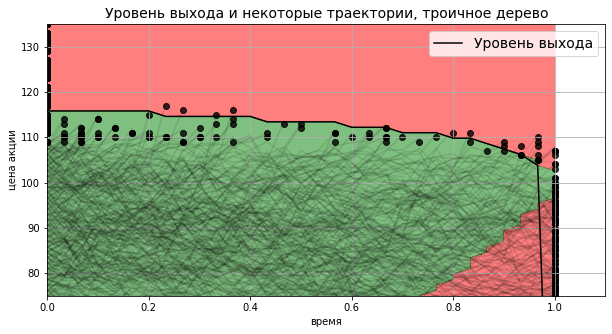

In [131]:
plt.figure(figsize=(10, 5))
plt.contourf(tn, sn, z_tree, levels=[-1, 0, 1], alpha = 0.5, colors=['r', 'g'])
plt.plot(tn, trajectory.T, 'k', alpha=0.1)
plt.plot(tn, B_tree, 'k', label='Уровень выхода')
plt.ylim((sn[0], sn[-1]))
plt.xlim((tn[0], tn[-1] + 0.1))
plt.scatter(t_expire, s_expire, c='k', alpha=0.8)
plt.legend(fontsize=14)
plt.title("Уровень выхода и некоторые траектории, троичное дерево", fontsize=14)
plt.xlabel("время")
plt.ylabel("цена акции")
plt.grid()

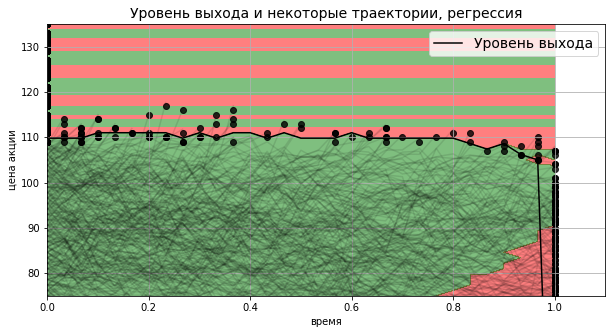

In [132]:
plt.figure(figsize=(10, 5))
plt.contourf(tn, sn, z_reg, levels=[-2, 0, 2], alpha = 0.5, colors=['r', 'g'])
plt.plot(tn, trajectory.T, 'k', alpha=0.1)
plt.plot(tn, B_reg, 'k', label='Уровень выхода')
plt.ylim((sn[0], sn[-1]))
plt.xlim((tn[0], tn[-1] + 0.1))
plt.scatter(t_expire, s_expire, c='k', alpha=0.8)
plt.legend(fontsize=14)
plt.title("Уровень выхода и некоторые траектории, регрессия", fontsize=14)
plt.xlabel("время")
plt.ylabel("цена акции")
plt.grid()


Выше представленны графики уровней выхода для двух моделей: троичного дерева и регрессии. Красным цветом закрашены области, в которых $V(t, s) \leq \Phi(s)$, зелёным -- в которых $V(t, s) > \Phi(s)$. Жирной черной линией изображены границы выходов. Черными тонкими линиями изображены некоторые траектории цен. Черными точками обозначены точки выхода. Видно, что для модели дерева зелёная область получилась односвязной, а линия границы выхода более гладкой. Для модели на основе регрессии зелёная область состоит из нескольких подобластей. В частности, верхние области соответствуют тем случаям, когда $V(t, s) < \Phi(s)$, что, вообще говоря, противоречит принципу безарбитражности.

На обоих графиках видно, что траектории, которые пересекают границу выхода снизу вверх в скором времени останавливаются, т.е. контракт исполняется. Также видно, что контракты, которые покидают зелёную область снизу вверх не исполняются, хотя в этих точках цена исполнения равна цене опциона. Как я понимаю, это связанно с тем, что в данных областях опцион не в деньгах и поэтому его нет смысла заканчивать досрочно, так как есть вероятность, что к концу срока контракта он будет в деньгах.